In [1]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn

import pandas as pd
import numpy as np
import models.nestd
import os

from theanomodels.utils.misc import loadHDF5
import utils
import h5py

Populating the interactive namespace from numpy and matplotlib


## Find files named 'config.json' and load them into a dataframe

In [36]:
configs = utils.extract_configs('output/002_10seeds/')
configs.iloc[:5]

output/002_10seeds/ApproxM2/cw128_seed1  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                       output/002_10seeds/ApproxM2/cw128_seed10  \
KL_loggamma_coef                                              1   
LogitNormalMP                                               NaN   
alpha_inference_layers                                        2   
annealBP                                                      1   
annealBound                                                   1   

                       output/002_10seeds/ApproxM2/cw128_seed2  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                       output/002_10seeds/ApproxM2/cw128_seed3  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                       output/002_10seeds/ApproxM2/cw128_seed4  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                       output/002_10seeds/ApproxM2/cw128_seed5  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                       output/002_10seeds/ApproxM2/cw128_seed6  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                       output/002_10seeds/ApproxM2/cw128_seed7  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                       output/002_10seeds/ApproxM2/cw128_seed8  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                       output/002_10seeds/ApproxM2/cw128_seed9  \
KL_loggamma_coef                                             1   
LogitNormalMP                                              NaN   
alpha_inference_layers                                       2   
annealBP                                                     1   
annealBound                                                  1   

                                             ..

## Get differences between runs

In [37]:
keys_that_are_different = []
keys_to_omit = ['timestamp']
for k in configs.index:
    if k not in keys_that_are_different:
        if (configs.T.duplicated(k,keep='first')==False).sum()>1:
            keys_that_are_different.append(k)

## Generate a name-mapping

In [39]:
keys_to_include = [
    'model',
    'sharpening',
    'seed',
]
defaults = {
    'sharpening': 1,
    'seed': 0,
}
remap_name = {
    'sharpening': 'shrp',
}

def generate_name(key,value):
    if key in remap_name:
        rkey = remap_name[key]
    else:
        rkey = key
    if value is None or value==False:
        return ''
    elif key in defaults and value==defaults[key]:
        return ''
    elif isinstance(value,bool) and value==True:
        return rkey
    elif key=='model':
        return value
    else:
        return '%s=%s' % (rkey,value)
    
name_map = {}
for c in configs.columns:
    name = configs.loc[keys_to_include,c]
    name_str_list = filter(len,map(generate_name,*zip(*name.iteritems())))
    name = ' '.join(name_str_list)
    name_map[c] = name

In [41]:
reverse_name_map = {v:k for k,v in name_map.iteritems()}

In [59]:
keys_to_include = [
    'model',
    'sharpening',
]
defaults = {
    'sharpening': 1,
}
remap_model_type = {
    'sharpening': 'shrp',
}

def generate_model_type(key,value):
    if key in remap_model_type:
        rkey = remap_model_type[key]
    else:
        rkey = key
    if value is None or value==False:
        return ''
    elif key in defaults and value==defaults[key]:
        return ''
    elif isinstance(value,bool) and value==True:
        return rkey
    elif key=='model':
        return value
    else:
        return '%s=%s' % (rkey,value)
    
model_type_map = {}
for c in configs.columns:
    model_type = configs.loc[keys_to_include,c]
    model_type_str_list = filter(len,map(generate_model_type,*zip(*model_type.iteritems())))
    model_type = ' '.join(model_type_str_list)
    model_type_map[c] = model_type

In [60]:
reverse_model_type_map = {v:k for k,v in model_type_map.iteritems()}

## Load results

In [42]:
results = models.nestd.NestD({k:loadHDF5(os.path.join(k,'output.h5')) for k in name_map})

## Calculate results across seeds

    First, add a level to the hierarchy with the model name

In [69]:
results2 = models.nestd.NestD({k:{model_type_map[k]:results[k]} for k in results})

    Next, collapse results along the first level (collapse will combine all leaves into a list for each keypath)

In [71]:
collapsed = results2.collapse(levels=[0])

In [72]:
collapsed.apply(len)[:,'train','accuracy']

NestD{
 ExactM2: 10
 LogisticNormal: 10
 LogisticNormalM2: 10
 STGumbelSoftmaxM2: 10
 LogGamma: 10
 MLP: 10
 GumbelSoftmaxM2 shrp=3.0: 10
 ApproxM2: 10
 LogisticNormalM2 shrp=3.0: 10}

    Next, concatenate each list at the leaves

In [73]:
def concatenate(X):
    return np.concatenate([np.expand_dims(x,-1) for x in X],axis=-1)

concatenated = collapsed.apply(concatenate)

In [74]:
concatenated.apply(np.shape)[:,'train','accuracy']

NestD{
 ExactM2: (301, 10)
 LogisticNormal: (301, 10)
 LogisticNormalM2: (301, 10)
 STGumbelSoftmaxM2: (301, 10)
 LogGamma: (301, 10)
 MLP: (301, 10)
 GumbelSoftmaxM2 shrp=3.0: (301, 10)
 ApproxM2: (301, 10)
 LogisticNormalM2 shrp=3.0: (301, 10)}

    Next, calculate statistics at each leaf

In [75]:
def calc_statistics(x):
    return models.nestd.NestD({
        'mean': np.mean(x,axis=-1),
        'median': np.median(x,axis=-1),
        'std': np.std(x,axis=-1),
        'p10': np.percentile(x,q=10,axis=-1),
        'p90': np.percentile(x,q=90,axis=-1),
    })

In [76]:
stats = concatenated.apply(calc_statistics)

## Plotting Functions

In [90]:
def plot_result(x,y=None,label=None,title=None,best_val_func=None,best_val_format=None,**plt_kwargs): 
    if y is None:
        y = x
        x = np.arange(len(y))
    if label is not None and best_val_func is not None:
        best_val = best_val_format.format(best_val_func(y['mean']))
        label = '%s (%0.0fep) %s' % (best_val,max(x),label)
    if label is not None:
        plt.plot(x,y['mean'],label=label,**plt_kwargs)
    else:
        plt.plot(x,y['mean'],**plt_kwargs)
    plt.fill_between(x,y['p10'],y['p90'],color='b',alpha=0.05,**plt_kwargs)
        
def plot_parameters(legend_loc=None,xlim=None,ylim=None,xlabel=None,ylabel=None,**kwargs):
    if legend_loc is not None:
        plt.legend(**legend_loc)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if ylim is not None:
        plt.ylim(*ylim)
    if xlim is not None:
        ply.xlim(*xlim)
        
        
def plot_experiment(results,keys=['accuracy','loss'],epoch_field='epoch',title=None,**kwargs):
    n = len(keys)
    for i,k in enumerate(keys):
        plt.subplot(1,n,i+1)
        for s in results[:,k]:
            epochs = results[s,epoch_field]
            if 'mean' in epochs:
                epochs = epochs['mean']
            vals = results[s,k]
            plot_result(epochs,vals,label=s,**kwargs[k]['result_settings'])
        if title is None:
            plt.title(k)
        else:
            plt.title('%s %s' % (title,k))
        plot_parameters(**kwargs[k]['plot_parameters'])

In [116]:
def plot_result(x,y=None,label=None,title=None,best_val=None,best_val_format=None,**kwargs): 
    if y is None:
        y = x
        x = np.arange(len(y))
    if label is not None and best_val is not None:
        best_val = best_val_format.format(best_val)
        label = '%s (%0.0fep) %s' % (best_val,max(x),label)
    if label is not None:
        plt.plot(x,y['mean'],label=label)
    else:
        plt.plot(x,y['mean'],**plt_kwargs)
    plt.fill_between(x,y['p10'],y['p90'],color='b',alpha=0.05)
        
def plot_parameters(legend_loc=None,xlim=None,ylim=None,xlabel=None,ylabel=None,**kwargs):
    if legend_loc is not None:
        plt.legend(**legend_loc)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if ylim is not None:
        plt.ylim(*ylim)
    if xlim is not None:
        ply.xlim(*xlim)

def get_best_val(x,y=None,best_val_func=None,**kwargs): 
    if y is None:
        y = x
        x = np.arange(len(y))
    if best_val_func is not None:
        return best_val_func(y['mean'])
    else:
        return None
        
def plot_experiment(results,keys=['accuracy','loss'],epoch_field='epoch',title=None,**kwargs):
    n = len(keys)
    for i,k in enumerate(keys):
        plt.subplot(1,n,i+1)
        vals = []
        for s in results[:,k]:
            epochs = results[s,epoch_field]
            if 'mean' in epochs:
                epochs = epochs['mean']
            v = get_best_val(epochs,results[s,k],**kwargs[k]['result_settings'])
            vals.append((v,s,epochs))
        if kwargs[k]['result_settings']['best_val_func'] == min:
            sorted_vals = sorted(vals,reverse=False)
        else:
            sorted_vals = sorted(vals,reverse=True)
        for best_val,s,ep in sorted_vals:
            plot_result(epochs,results[s,k],label=s,best_val=best_val,**kwargs[k]['result_settings'])
        if title is None:
            plt.title(k)
        else:
            plt.title('%s %s' % (title,k))
        plot_parameters(**kwargs[k]['plot_parameters'])

## Plot Results

In [117]:
plot_settings = {
    'accuracy': {
        'result_settings': {
            'best_val_func': max,
            'best_val_format': '{:0.3f}',
        },
        'plot_parameters': {
            'legend_loc': {'loc':'lower right'},
            'ylim':(0.5,1),
            'xlabel':'epochs',
        }
    },
    'loss': {
        'result_settings': {
            'best_val_func': min,
            'best_val_format': '{:0.1f}',
        },
        'plot_parameters': {
            'legend_loc': {'loc':'upper left'},
            'ylim':(100,1000),
            'xlabel':'epochs',
        }
    },
    
}

In [118]:
seaborn.set_palette(seaborn.color_palette("hls", len(stats)))

In [119]:
if not os.path.exists('plots'):
    os.system('mkdir plots')

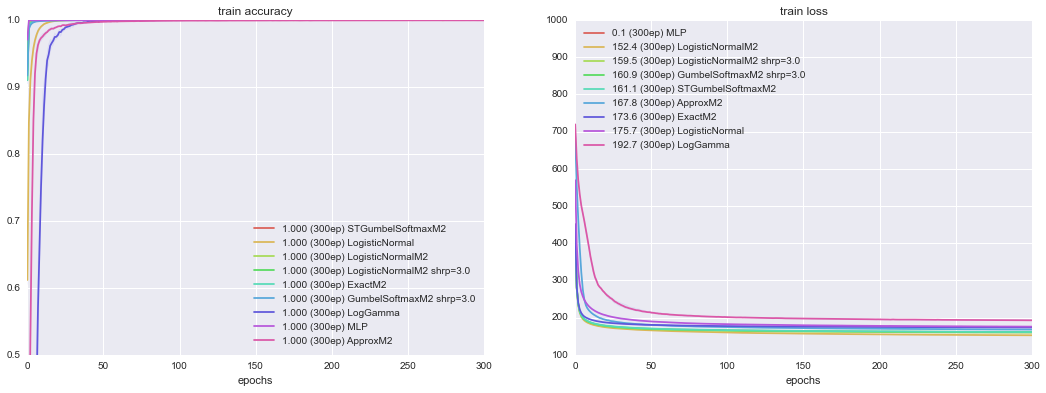

In [120]:
plt.figure(1,figsize=(18,6),dpi=320)
plot_experiment(stats[:,'train'],title='train',**plot_settings)
plt.savefig('plots/multi_seed_accuracy_loss_train.png')

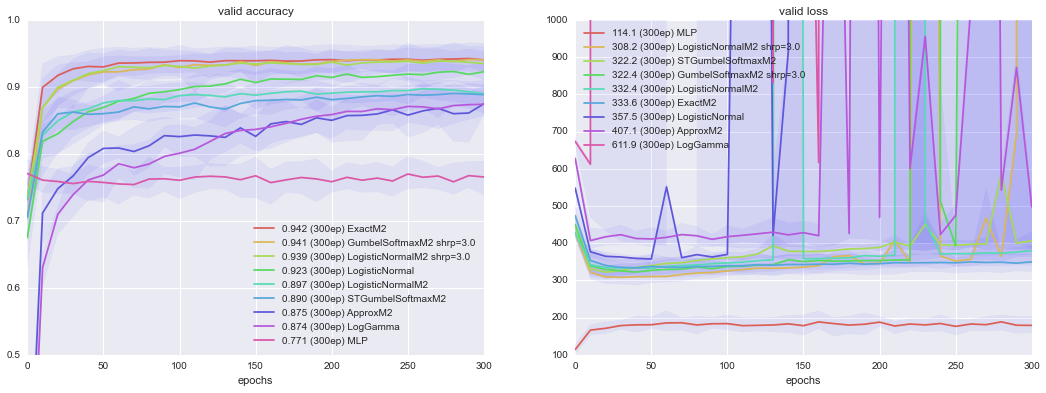

In [121]:
plt.figure(1,figsize=(18,6),dpi=320)
plot_experiment(stats[:,'valid'],title='valid',**plot_settings)
plt.savefig('plots/multi_seed_accuracy_loss_validation.png')

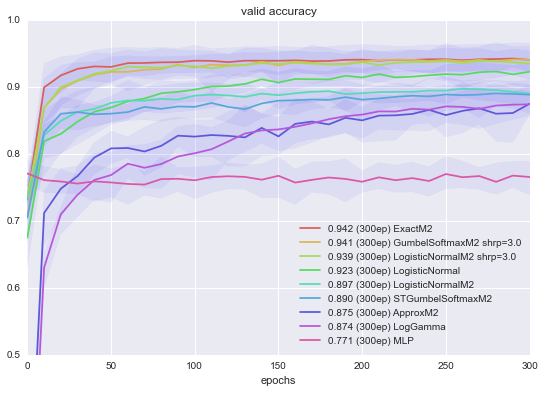

In [122]:
plt.figure(1,figsize=(9,6),dpi=320)
plot_experiment(stats[:,'valid'],keys=['accuracy'],title='valid',**plot_settings)
plt.xlabel('epochs')
os.system('mkdir plots')
plt.savefig('plots/multi_seed_accuracy_validation.png')

## KL_Z: load mu & logcov2 from output_verbose

In [123]:
def applyfunc(d):
    if isinstance(d,h5py.Group):
        return models.nestd.NestD(d).apply(applyfunc)
    else:
        return d
    
def deepcopy(f):
    if isinstance(f,h5py.Group):
        y = {}
        for k,v in f.iteritems():
            y[k] = deepcopy(v)
        return y
    else:
        return f

def load_mu_logcov2(filepath):
    with h5py.File(filepath,'r') as f:
        x = deepcopy(f)
        x = models.nestd.NestD(x)
        x = x[:,:,['mu','logcov2']]
        x = x.apply(lambda v:v.value)
    return x

def load_y(filepath):
    with h5py.File(filepath,'r') as f:
        return models.nestd.NestD(f).apply(applyfunc)[:,:,['y']].apply(np.array)

In [124]:
results_mu_logcov = {}
for k in sorted(name_map):
    filepath = os.path.join(k,'output_verbose.h5')
    x = loadHDF5(filepath)
    x = models.nestd.NestD(x)
    x = x[:,:,['mu','logcov2']]
    results_mu_logcov[name_map[k]] = x

In [125]:
results_mu_logcov = models.nestd.NestD(results_mu_logcov)

## KL_Z: Calculate KL

In [126]:
def find_and_apply(x,findfunc,applyfunc):
    if isinstance(x,models.nestd.NestD):
        if findfunc(x):
            return applyfunc(x)
        else:
            y = models.nestd.NestD()
            for k in x:
                y[k] = find_and_apply(x[k],findfunc,applyfunc)
            return y
    else:
        return x

def gaussian_kl(mu,logcov2):
    return models.nestd.NestD({'KL':0.5*(np.exp(logcov2)+mu**2.0-1.0-logcov2)})

find_keys = ['mu','logcov2']
results_KL = find_and_apply(results_mu_logcov,
                            findfunc=lambda x: all([k in x for k in find_keys]),
                            applyfunc=lambda x: {k:x[k] for k in find_keys}).apply(lambda x: gaussian_kl(**x))


## KL_Z: plot the KL divergence at each latent Z node over iterations

In [128]:
def plot_KL_heatmap(data,title=None,xticks=None,figsize=(18,5)):
    plt.figure(1,figsize=figsize)
    plt.pcolor(data.T,cmap='jet')
    plt.xlim(0,data.shape[0])
    plt.ylim(0,data.shape[1])
    if xticks is not None:
        plt.xticks(xticks)
    if title is not None:
        plt.title(title)
    plt.xlabel('examples ordered by iteration #')
    plt.ylabel('Z index')

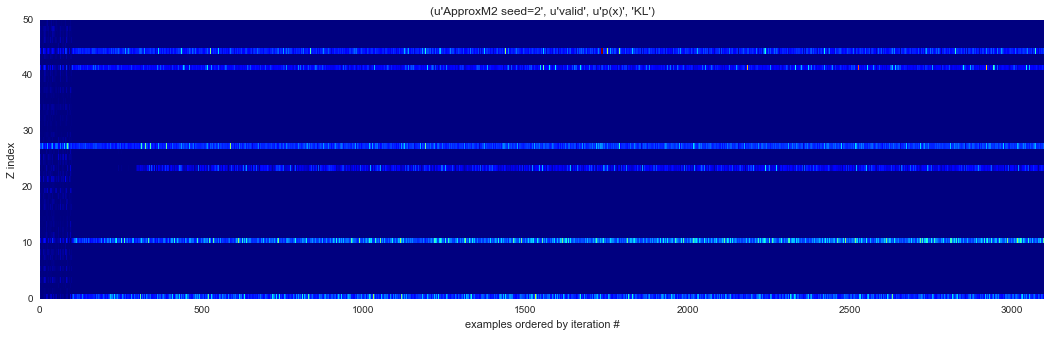

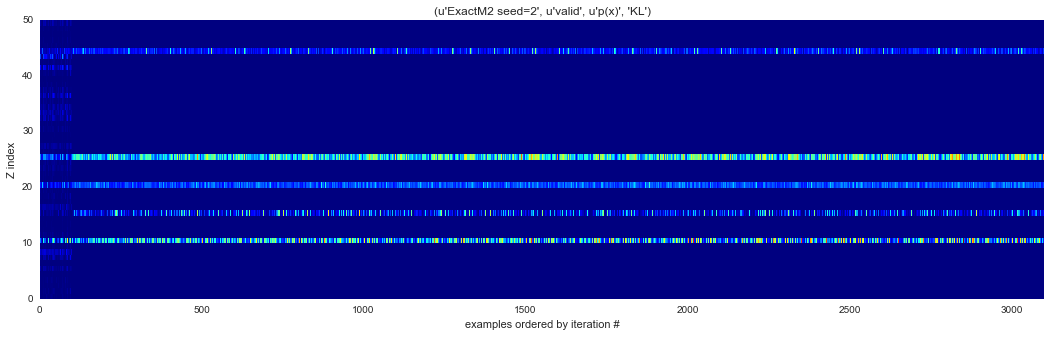

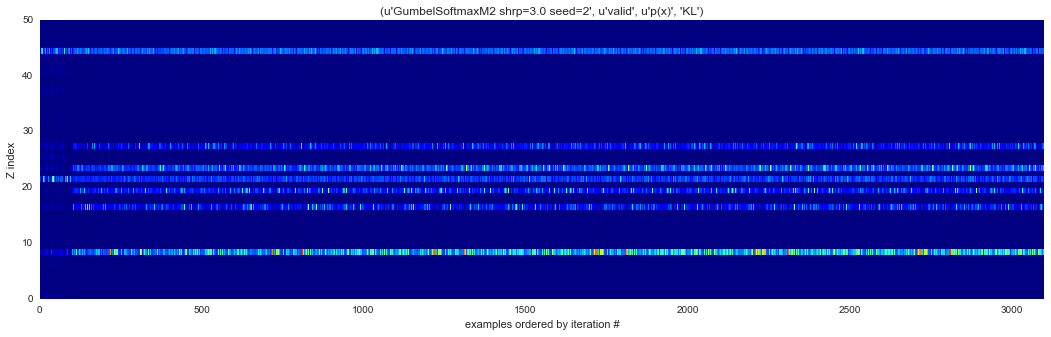

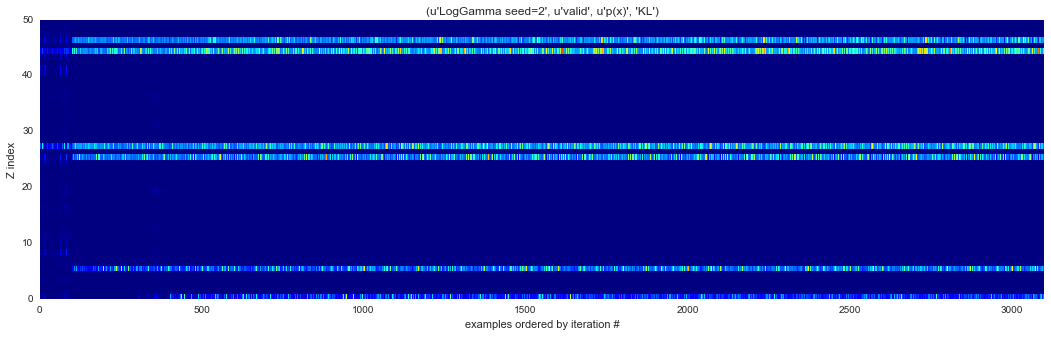

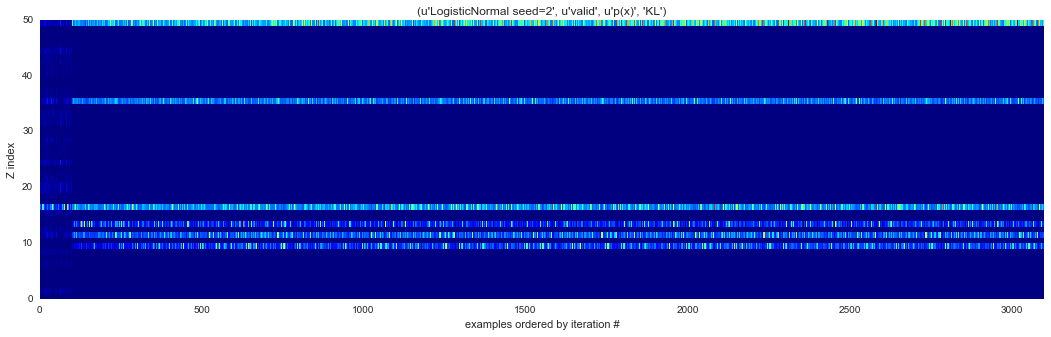

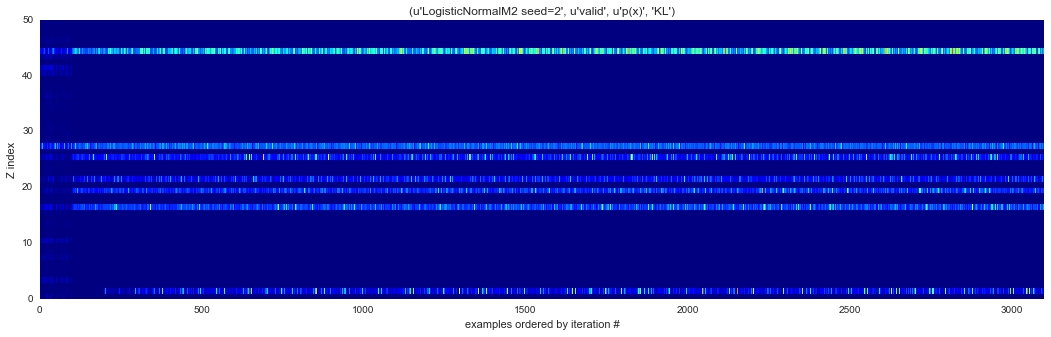

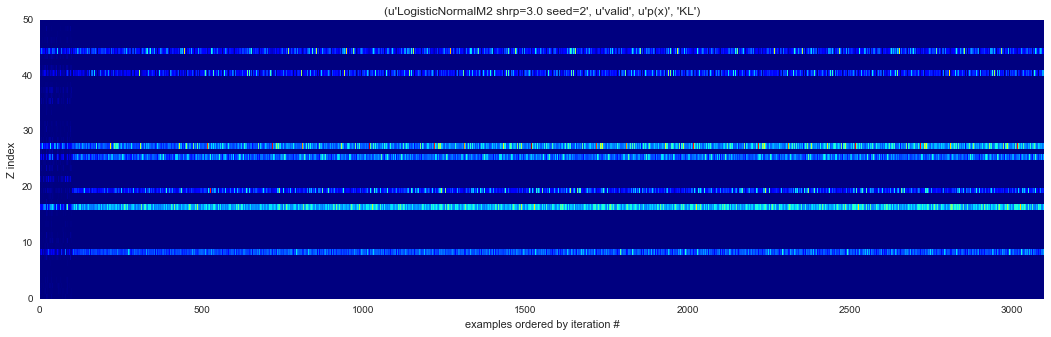

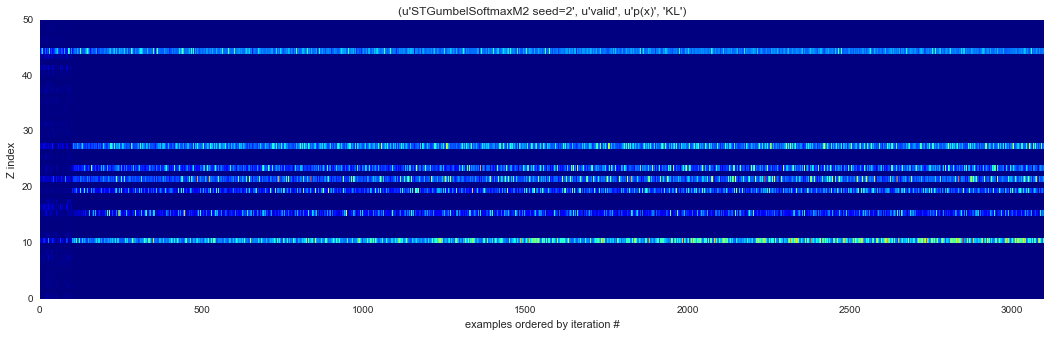

In [138]:
for kl_name,kl in sorted(list(results_KL[:,['valid'],['p(x)']].walk())):
    if 'seed=2' in kl_name[0]:
        plot_KL_heatmap(kl,kl_name)
        plt.savefig('plots/KL_Z_%s.png' % kl_name[0].replace(' ','_').replace('=',''))
        plt.show()

## Samples

In [130]:
samples = {}
for k in sorted(name_map):
    filepath = os.path.join(k,'samples.h5')
    if os.path.exists(filepath):
        with h5py.File(filepath,'r') as f:
            x = deepcopy(f)
            x = models.nestd.NestD(x)
            x = x.apply(lambda v:v.value)
        samples[name_map[k]] = x
samples = models.nestd.NestD(samples)

In [ ]:
samples_reshaped = samples.prune().apply(lambda x: x.reshape(-1,28,28))

In [132]:
def todisplayimage(x,cols=25,sep=3,split=100):
    n,m1,m2 = x.shape
    Y = []
    for s in range(0,n,split):
        rows = int(np.ceil(split/float(cols)))
        y = np.zeros((rows*(m1+sep),cols*(m2+sep)))
        c=0
        for j in range(s,min(n,s+split)):
            i = j % split
            c = i % cols
            r = int(np.floor(i/cols))
            #print s,i,n,r*(m1+sep),r*(m1+sep)+m1,c*(m2+sep),c*(m2+sep)+m2
            y[r*(m1+sep):r*(m1+sep)+m1,c*(m2+sep):c*(m2+sep)+m2] = x[j]
        Y.append(y)
    YY = [Y[0]]
    for y in Y[1:]:
        YY.append(np.zeros((sep*4,cols*(m2+sep))))
        YY.append(y)    
    return np.concatenate(YY,axis=0)

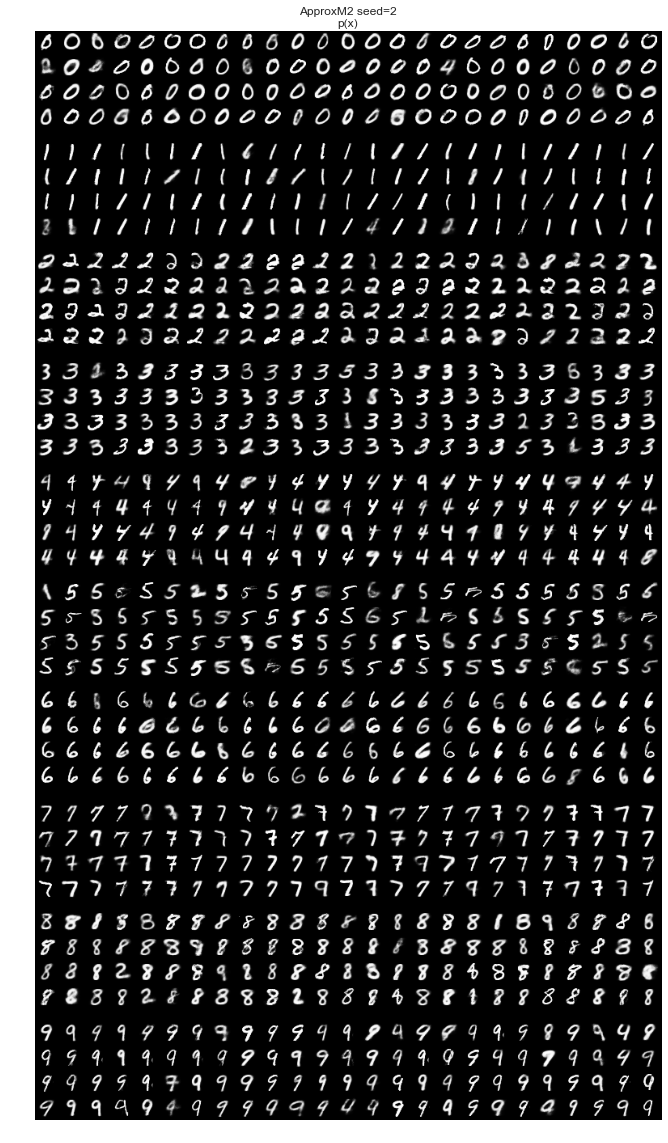

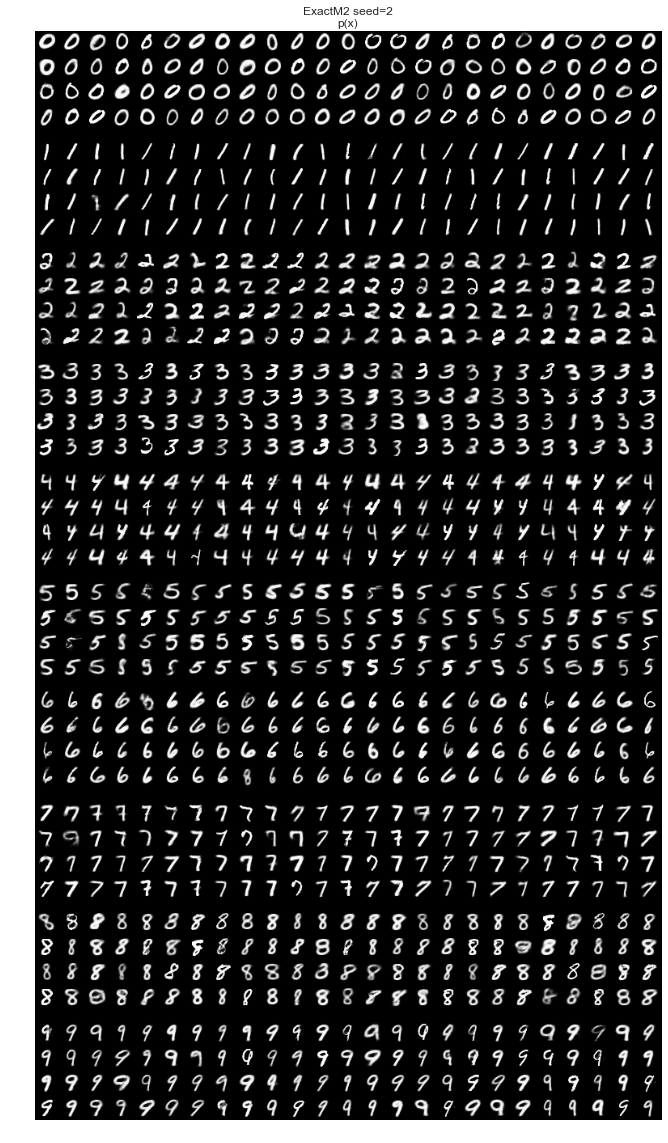

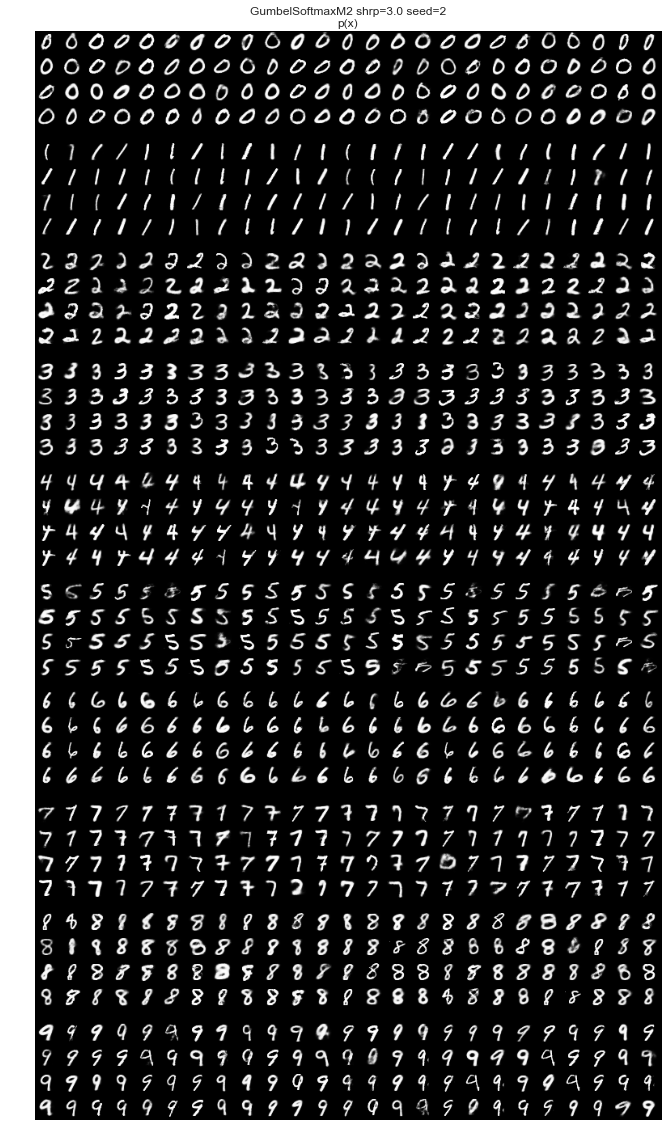

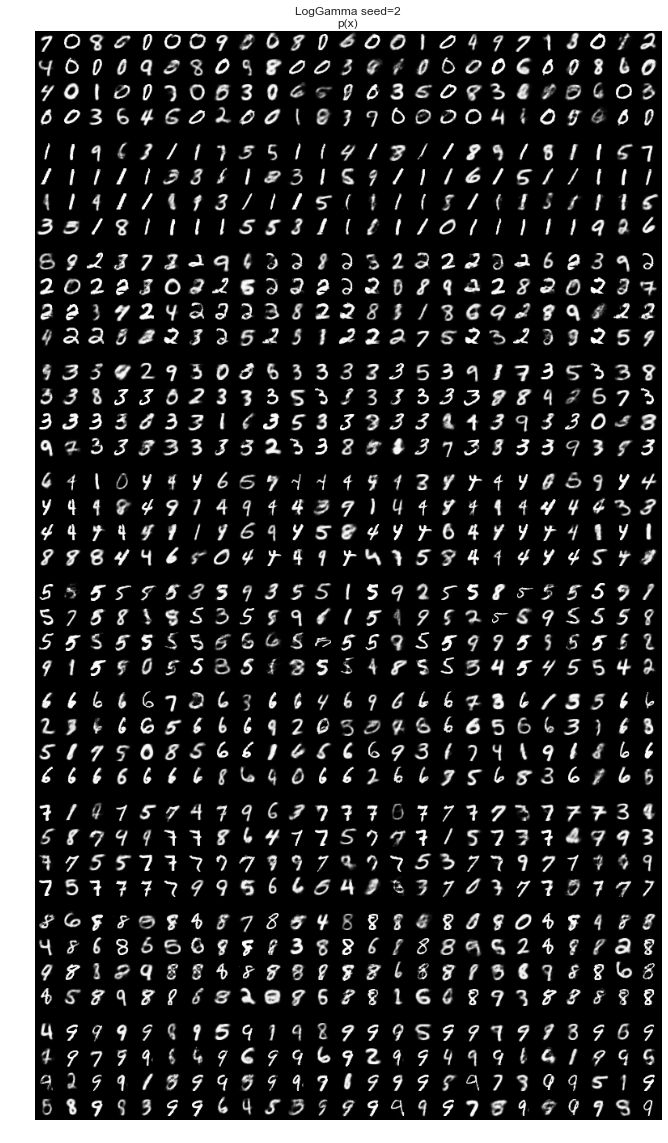

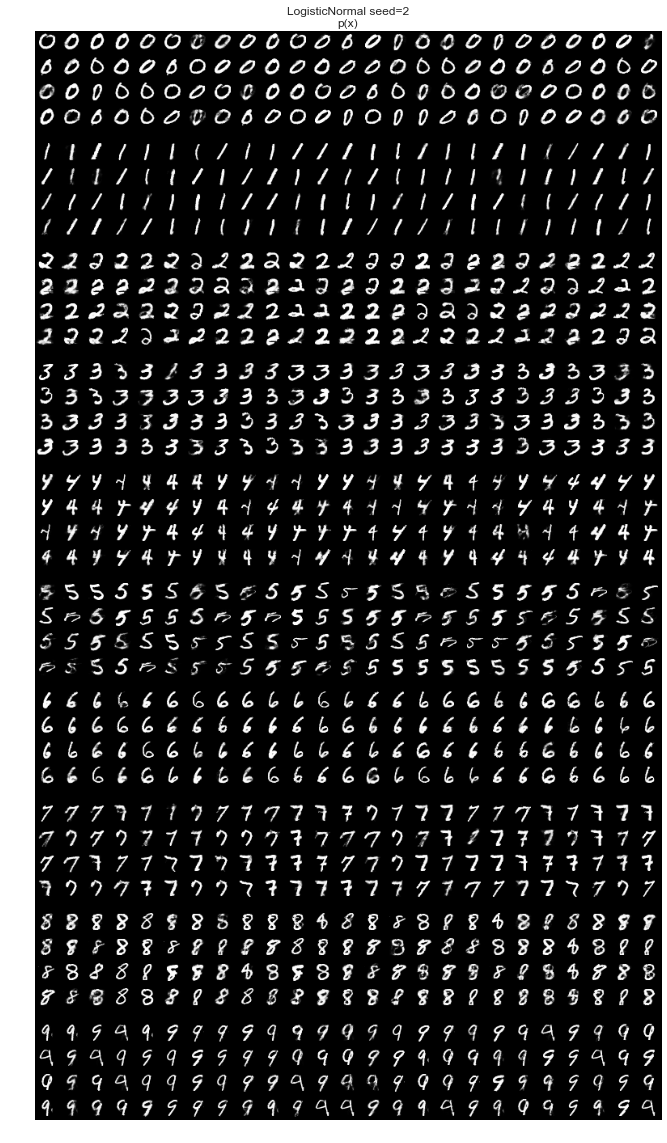

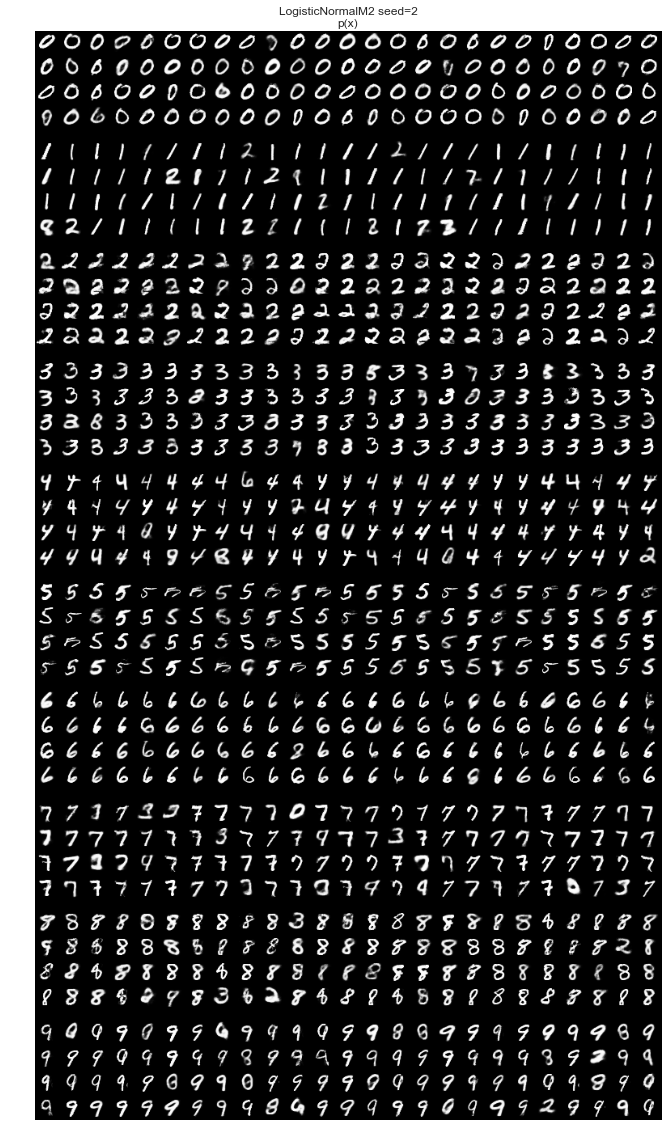

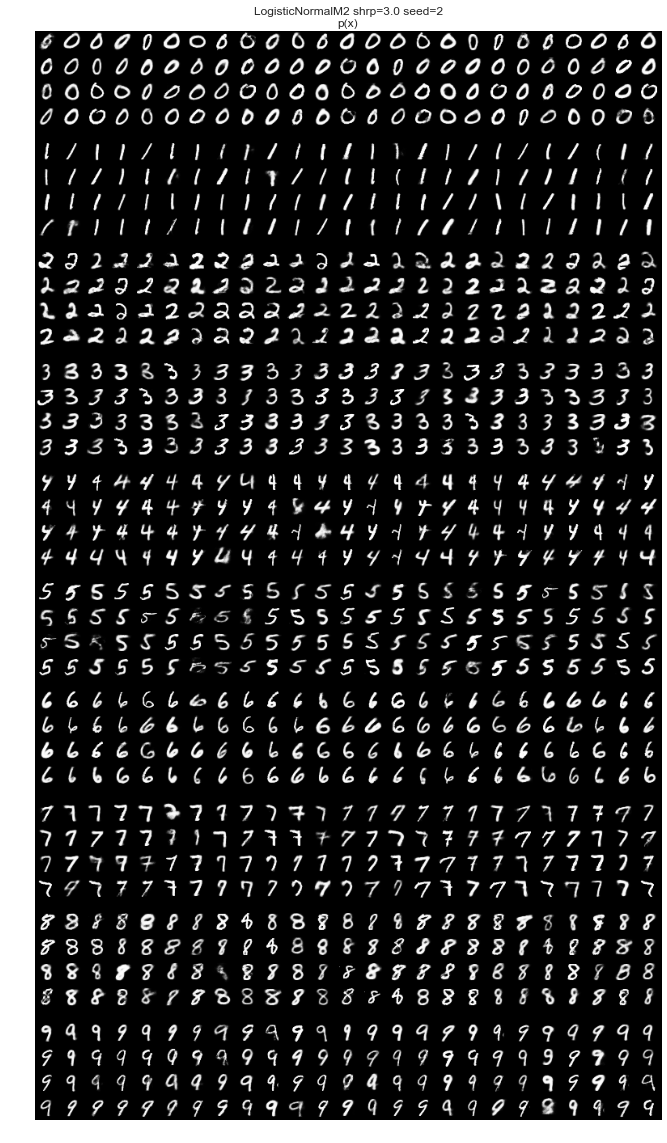

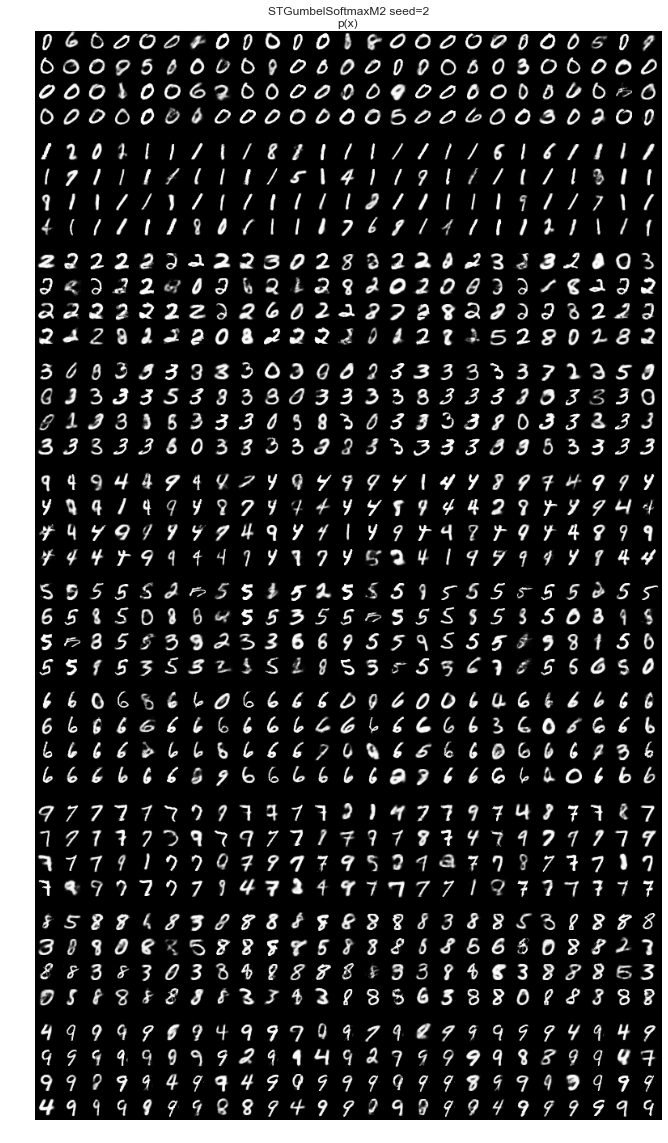

In [136]:
for k in sorted(samples_reshaped):
    if 'seed=2' in k:
        plt.figure(1,figsize=(16,16))
        plt.imshow(1-todisplayimage(samples_reshaped[k,'p(x)','p'][-1000:]))
        plt.gca().grid(False)
        plt.title('%s\np(x)' % (k))
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('plots/samples_%s.png' % k.replace(' ','_').replace('=',''))
        plt.show()